In [3]:
import sys
import os
# Sorry for this code : (
sys.path.append('../')

import numpy as np
import matplotlib
from matplotlib import pyplot as plt


import loader

import importlib
importlib.reload(loader)

parent =  os.path.abspath("../")
path_to_hearts = os.path.join(parent, 'hearts')

COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

In [1]:
sim_time_minutes = 18
cores = 10
sim_s_to_rl_m = 2 # Worst case scenario
max_buffer_size = 10_000
size_state = 8
size_action = 4
float_size = 8
sampling_frequency = 20

comp_time_minutes = sim_time_minutes * 60 * sim_s_to_rl_m
days = int((comp_time_minutes / 60) // 24)
hours = int((comp_time_minutes / 60) - (days * 24))
minutes = int(comp_time_minutes - (days * 24 * 60 + hours * 60))
seconds = int((comp_time_minutes * 60) - (days * 24 * 3600 + hours * 3600 + minutes * 60))

sim_data_hours = (sim_time_minutes * cores) / 60
tot_hours = comp_time_minutes / 60

mem_total_bytes = (size_state + size_action) * float_size * max_buffer_size * cores
mem_total_GB = mem_total_bytes / 1_000_000_000

samples_per_core = sim_time_minutes * 60 * sampling_frequency 
sampels_total = samples_per_core * cores

t_end = sim_time_minutes * 60 * 1_000

print(f"Total hours: {tot_hours}")
print(f"T_end: {t_end}")
print(f"Comp time: {days}-{hours}:{minutes}:{seconds}")
print(f"Required memory: {mem_total_GB} GB")
print(f"Available data: {sim_data_hours} hours")
print(f"Available samplese: {sampels_total}")

Total hours: 36.0
T_end: 1080000
Comp time: 1-12:0:0
Required memory: 0.0096 GB
Available data: 3.0 hours
Available samplese: 216000


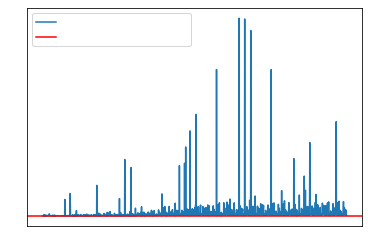

In [59]:
all_states, all_actions, t_start, t_end, par, name = loader.load_experiment(
    "ref_non_disturbed",
    path_to_hearts
)

uProbes = all_states[0]

all_states, all_actions, t_start, t_end, par, name = loader.load_experiment(
    "ref_disturbed",
    path_to_hearts
)

dProbes = all_states[0]


diffs = np.linalg.norm(dProbes - uProbes, axis=1)

N = 2
diffs_mean = np.convolve(diffs, np.ones(N)/N, mode='sane')

t = np.linspace(t_start, t_end, num=diffs.size) / 1_000
#plt.plot(t, diffs, label="actual")
plt.plot(t, diffs, label="Difference in the system")
plt.axhline(1e-3, color="red", label=f"disturbance level {1e-3}")
plt.legend()


(21600, 8)
(21600, 4)


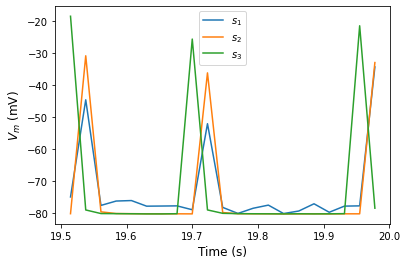

In [22]:
all_states, all_actions, t_start, t_end, par, name = loader.load_experiment(
    "peregrine_big",
    path_to_hearts
)

states = all_states[0]
actions = all_actions[0]

print(states.shape)
print(actions.shape)
t = np.linspace(t_start, 10_000 / 20, num=states.shape[0])

indicies = (t > 19.5) & (t < 20)

showcase = states.T
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("$V_m$ (mV)", fontsize=12)
plt.plot(t[indicies], showcase[0][indicies], label="$s_1$")
plt.plot(t[indicies], showcase[1][indicies], label="$s_2$")
plt.plot(t[indicies], showcase[2][indicies], label="$s_3$")
#plt.plot(t[indicies], showcase[2][indicies])
#plt.plot(t[indicies], showcase[1][indicies], label="$s_2$")
plt.legend()
# plt.savefig("../../Figures/ref-signal-example.pdf")

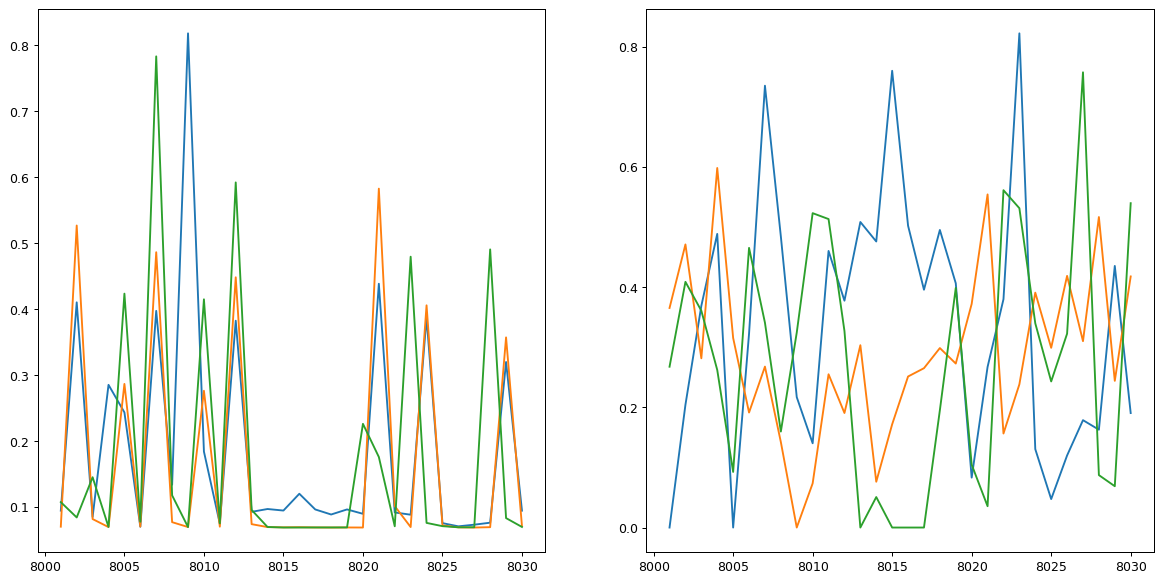

In [20]:
generator = loader.load_experiment_generator(
    "peregrine_big",
    os.path.abspath(os.path.join("..", 'hearts'))
)

states, actions = next(generator)

s_min, s_max = [-90.0, 50.0]
a_min, a_max = [0.0, 60.0]

s_shape = states.shape
#states = np.reshape(states, (s_shape[0], s_shape[1], 1))
a_shape = actions.shape
#actions = np.reshape(actions, (a_shape[0], a_shape[1], 1))

n_samples = s_shape[0]

states = (states - s_min) / (s_max - s_min)
actions = (actions - a_min) / (a_max - a_min)

fig, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=90)

ts = np.arange(n_samples)
begin = 8000
window = 30
indicies = (ts > begin) & (ts <= (begin + window)) 

ax[0].plot(ts[indicies], states.T[0][indicies])
ax[0].plot(ts[indicies], states.T[1][indicies])
ax[0].plot(ts[indicies], states.T[2][indicies])

ax[1].plot(ts[indicies], actions.T[0][indicies])
ax[1].plot(ts[indicies], actions.T[1][indicies])
ax[1].plot(ts[indicies], actions.T[2][indicies])

plt.show()

(21600, 8)


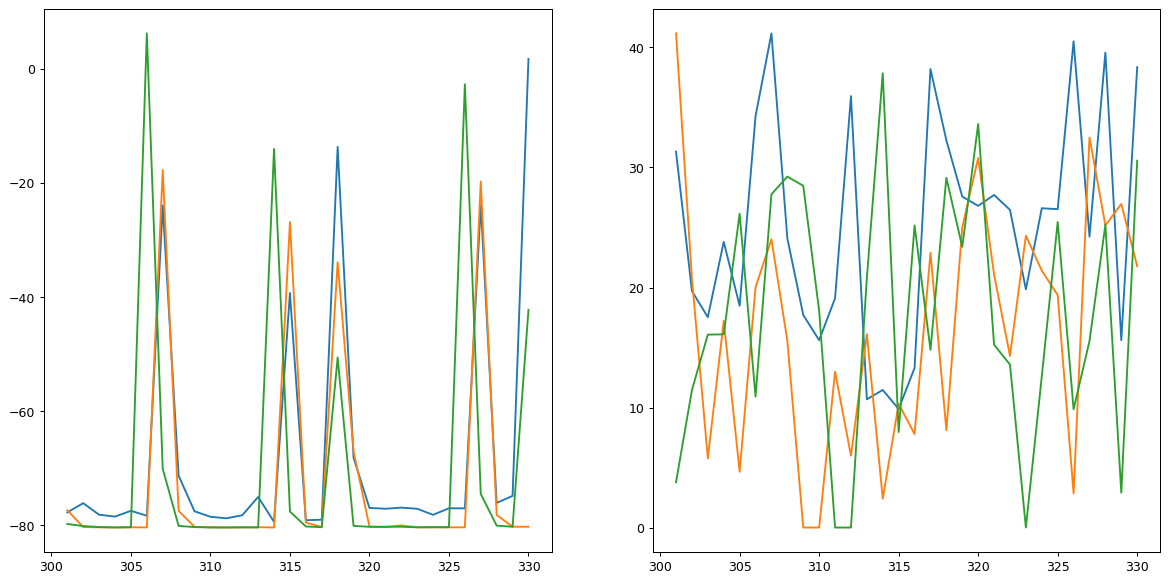

In [11]:
generator = loader.load_experiment_generator(
    "peregrine_big",
    os.path.abspath(os.path.join("..", 'hearts'))
)

states, actions = next(generator)

fig, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=90)

n_samples = states.shape[0]
print(states.shape)

ts = np.arange(n_samples)
begin = 300
window = 30
indicies = (ts > begin) & (ts <= (begin + window)) 

ax[0].plot(ts[indicies], states.T[0][indicies])
ax[0].plot(ts[indicies], states.T[1][indicies])
ax[0].plot(ts[indicies], states.T[2][indicies])

ax[1].plot(ts[indicies], actions.T[0][indicies])
ax[1].plot(ts[indicies], actions.T[1][indicies])
ax[1].plot(ts[indicies], actions.T[2][indicies])

In [6]:
import numpy as np
import scipy.sparse as sp

def pick_random_non_zero_value_indices(avail, n):
    hack = np.min(avail) - 1
    indices = np.array(np.where(avail > hack))
    shuffle_indices = np.arange(indices.shape[1])
    np.random.shuffle(shuffle_indices)

    indices[0,:] = indices[0, shuffle_indices]
    indices[1,:] = indices[0, shuffle_indices]
    
    chosen = []

    for i, j in indices.T:
        if avail[i, j] != 0 and len(chosen) < n:
            chosen.append([i, j])

    if len(chosen) < n:
        raise ValueError("Not enough non-zero elements in the avail matrix")

    return chosen

test = sp.random(6, 6, density=0.5, format="bsr").toarray()
print("MAtrix")
print(test)

rows_i = np.random.choice(
    np.arange(test.shape[0]),
    size=3,
    replace=False
)

test  = test[rows_i,:]
print("Chosen rows")

print(rows_i)
print(test)

indicies = pick_random_non_zero_value_indices(test, 4)
print(indicies)

MAtrix
[[0.9226882  0.         0.65276988 0.         0.30429821 0.        ]
 [0.22896123 0.         0.42691212 0.56089946 0.         0.79113737]
 [0.         0.         0.         0.91138772 0.55934947 0.97962789]
 [0.         0.48170756 0.         0.         0.         0.88760253]
 [0.99531793 0.         0.21676574 0.         0.         0.47794771]
 [0.73432    0.         0.15883174 0.         0.20029853 0.        ]]
Chosen rows
[2 3 5]
[[0.         0.         0.         0.91138772 0.55934947 0.97962789]
 [0.         0.48170756 0.         0.         0.         0.88760253]
 [0.73432    0.         0.15883174 0.         0.20029853 0.        ]]
[[1, 1], [2, 2], [2, 2], [2, 2]]


(21600, 2)


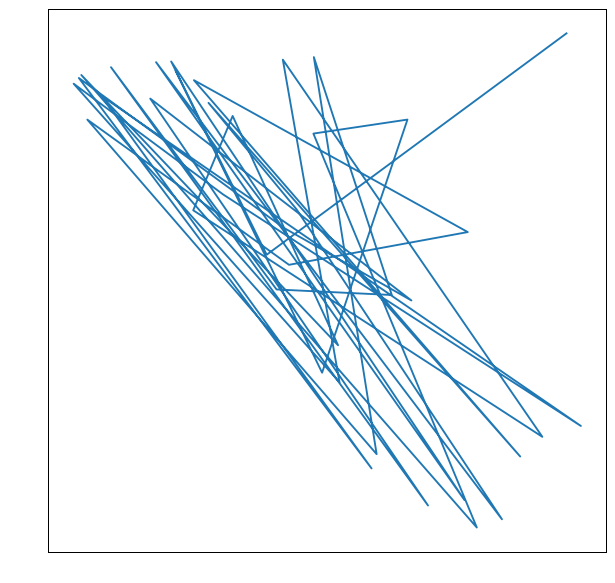

In [24]:
generator = loader.load_experiment_generator(
    "peregrine_all",
    os.path.abspath(os.path.join("..", 'hearts'))
)

states, actions = next(generator)


s_min, s_max = [-90, 50]
states = (states - s_min) / (s_max - s_min)

u = states - np.mean(states, axis=0)

cov_mat = np.cov(u, rowvar = False)

eival, eivec = np.linalg.eigh(cov_mat)


sorted_index = np.argsort(eival)[::-1]
eivec = eivec[:,sorted_index]
eival = eival[sorted_index]

to = 2
M_pca = eivec[:,:to]

ds = np.dot(M_pca.T, u.T).T

showcase = ds[:40,:].T


fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=90)
ax.plot(showcase[0], showcase[1])
plt.show()



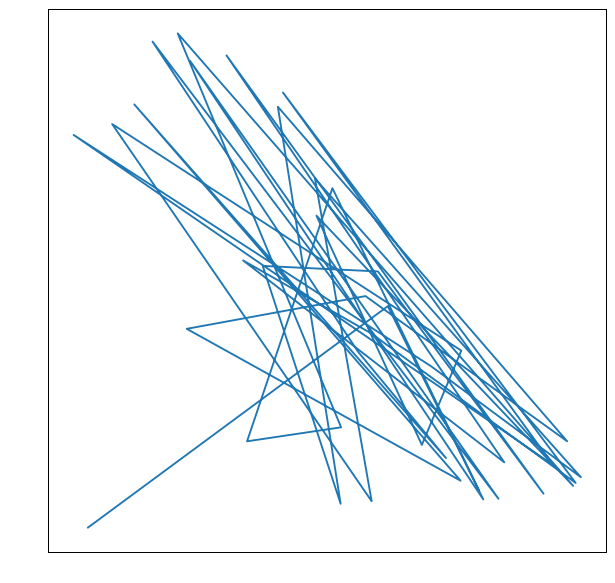

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
u_ds =  pca.fit_transform(u)

showcase = u_ds[:40,:].T


fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=90)
ax.plot(showcase[0], showcase[1])
plt.show()

In [16]:
import json
from sklearn.decomposition import PCA

def to_PCA(src, components):
    data = np.load(src)
    if data.ndim > 2:
        data = np.reshape(data, (data.shape[0], -1))
    data = data - np.mean(data, axis=0)

    pca = PCA(n_components=components)
    trajectory = pca.fit_transform(data).T

    x_min, x_max = np.min(trajectory[0]), np.max(trajectory[0])
    trajectory[0] = (trajectory[0] - x_min) / (x_max - x_min)

    y_min, y_max = np.min(trajectory[1]), np.max(trajectory[1])
    trajectory[1] = (trajectory[1] - y_min) / (y_max - y_min) 

    return trajectory




In [20]:
disturbed = to_PCA("../hearts/ref_disturbed/data/states_0_0.npy", 3)

with open("../../../chaotic_visuals/data/disturbed.json", "w") as f:
    json.dump(disturbed.tolist(), f)

(3, 1600)


In [18]:
non_disturbed = to_PCA("../hearts/ref_non_disturbed/data/states_0_0.npy", 3)

with open("../../../chaotic_visuals/data/non_disturbed.json", "w") as f:
    json.dump(non_disturbed.tolist(), f)

In [31]:
trajectory = to_PCA("../roentgen/video.npy", 3)

with open("../../../chaotic_visuals/data/non_disturbed.json", "w") as f:
    data = json.dumps(trajectory.tolist())

    f.write(data)

In [27]:
trajectory = to_PCA("../roentgen/video.npy", 2)


with open("../roentgen/trajectory.js", "w") as f:
    data = json.dumps(trajectory.tolist())

    f.write(f"var trajectory = {data};")
